## Akhil Karri
## AI Generated Text Detection
#### Data set downloaded from Kaggle
#### Accuracy : 99.3%

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, precision_score, f1_score, recall_score

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, BatchNormalization, LSTM, Dense, Dropout

from tqdm import tqdm
tqdm.pandas()
from collections import Counter

In [ ]:
# read data
df = pd.read_csv('Training_Essay_Data.csv')
print(df.shape)
df.head()

(29145, 2)


,text,generated
0,Car-free cities have become a subject of incre...,1
1,"Car Free Cities Car-free cities, a concept ga...",1
2,A Sustainable Urban Future Car-free cities ...,1
3,Pioneering Sustainable Urban Living In an e...,1
4,The Path to Sustainable Urban Living In an ...,1


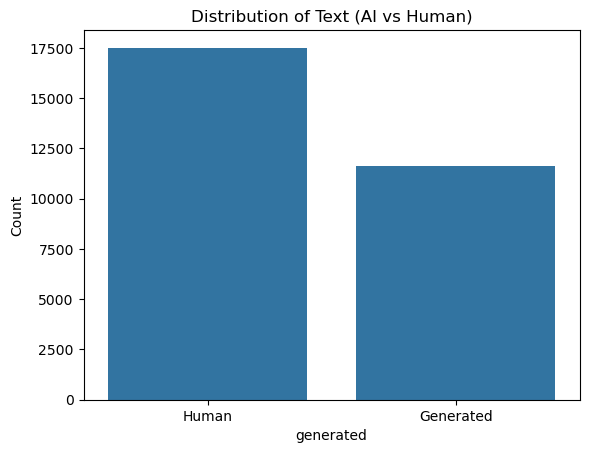

Count of Human vs Generated text:
generated
0    17508
1    11637
Name: count, dtype: int64


In [ ]:
# Plot the distribution of the 'generated & Humans' labels
ax = sns.countplot(x=df['generated'])
plt.title('Distribution of Text (AI vs Human)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Human', 'Generated'])
plt.show()

# Print the count
generated_count = df['generated'].value_counts()
print(f"Count of Human vs Generated text:\n{generated_count}")


In [ ]:
# length of the longest and smallest text
print(f"Length of the longest text: {df['text'].str.len().max()}")
print(f"Length of the smallest text: {df['text'].str.len().min()}")

Length of the longest text: 9157
Length of the smallest text: 1


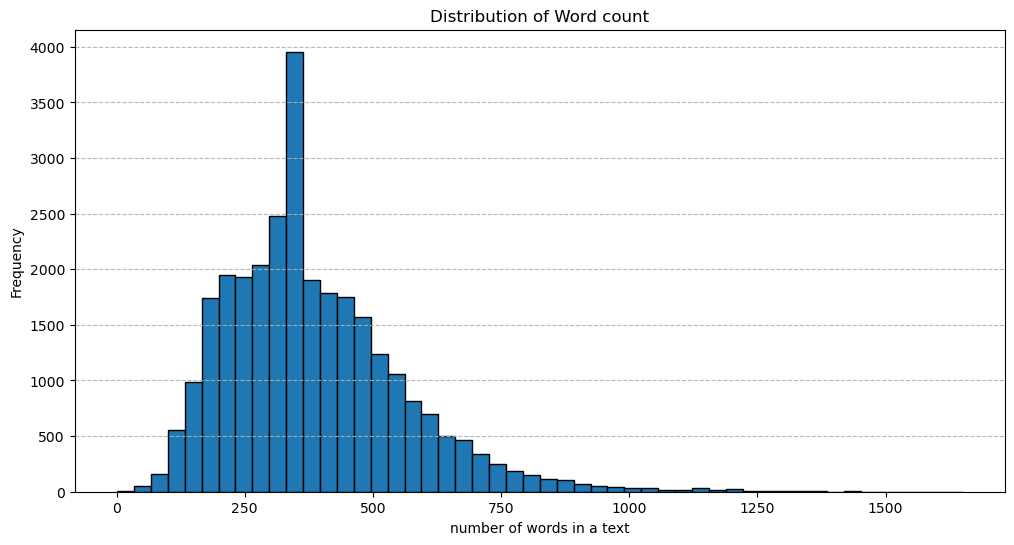

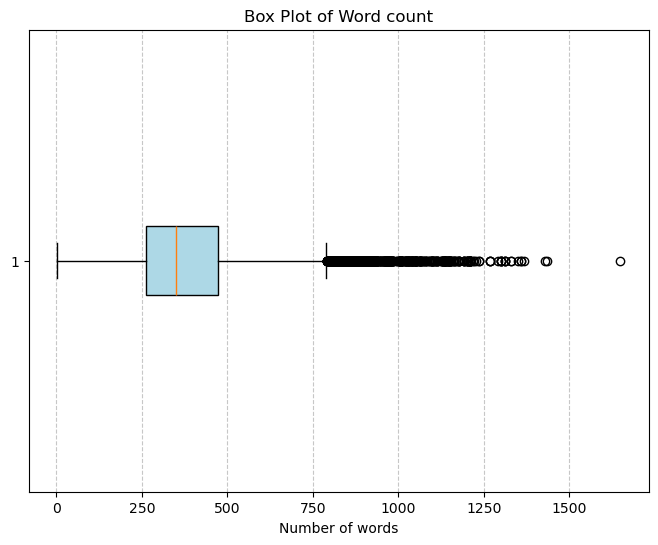

Average word count: 383.14
Median  word count: 351
Minimum word count: 1
Maximum word count: 1650


In [ ]:
# Distribution chart of word counts

# Calculate text lengths
text_lengths = [len(text.split()) for text in df['text']]

# Plot the histogram
plt.figure(figsize=(12, 6))
plt.hist(text_lengths, bins=50,  edgecolor='black')
plt.title('Distribution of Word count')
plt.xlabel('number of words in a text')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.9)
plt.show()

# Plot the box plot
plt.figure(figsize=(8, 6))
plt.boxplot(text_lengths, vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('Box Plot of Word count')
plt.xlabel('Number of words')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Print stats
print(f"Average word count: {sum(text_lengths) / len(text_lengths):.2f}")
print(f"Median  word count: {sorted(text_lengths)[len(text_lengths) // 2]}")
print(f"Minimum word count: {min(text_lengths)}")
print(f"Maximum word count: {max(text_lengths)}")

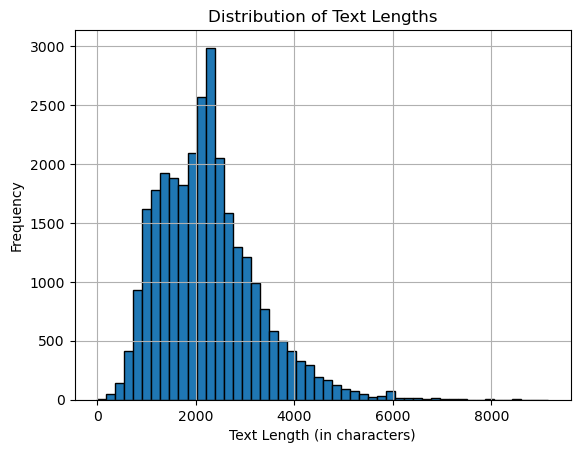

Mean   text length: 2235.996740435752
Median text length: 2158.0
Max    text length: 9157
Min    text length: 1


In [ ]:
# Distribution graph for text lengths

# Calculate the length of each text (in characters)
text_lengths = df['text'].apply(len)
plt.hist(text_lengths, bins=50, edgecolor='black')
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length (in characters)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# print stats
print("Mean   text length:", np.mean(text_lengths))
print("Median text length:", np.median(text_lengths))
print("Max    text length:", np.max(text_lengths))
print("Min    text length:", np.min(text_lengths))

In [ ]:
# Filter texts with word counts between 170 and 500 for an even distribution and helps model for better generalization
filtered_by_word_count_df = df[df['text'].apply(lambda x: 170 <= len(x.split()) <= 500)]

# print the shape of the filtered DataFrame
print(f"Filtered DataFrame shape: {filtered_by_word_count_df.shape}")

Filtered DataFrame shape: (21118, 2)


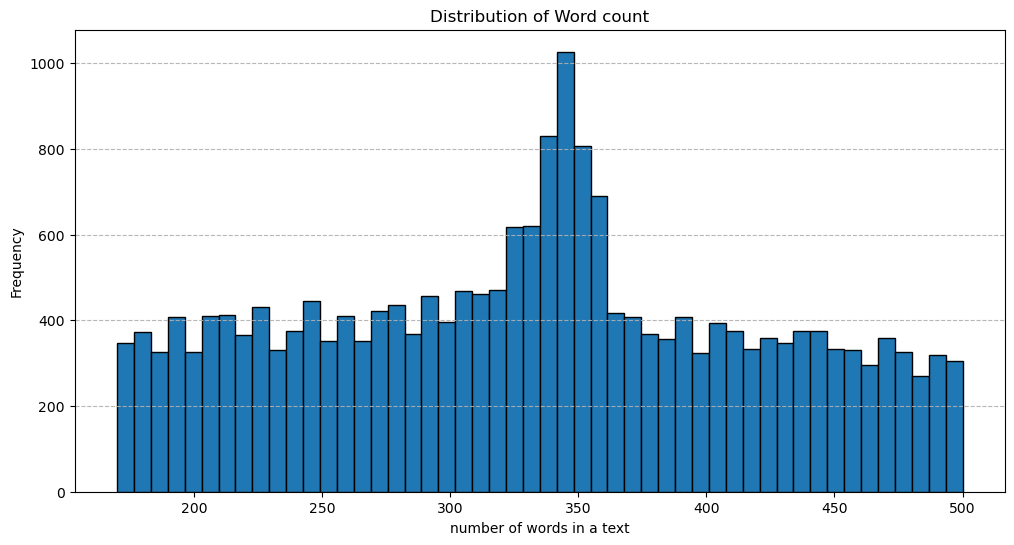

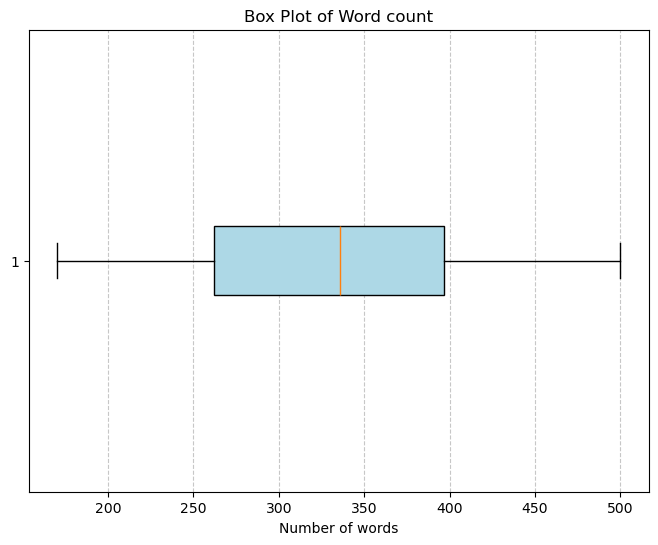

Average word count: 331.64
Median  word count: 336
Minimum word count: 170
Maximum word count: 500


In [ ]:
# Distribution after filtering by word count

text_lengths = [len(text.split()) for text in filtered_by_word_count_df['text']]

plt.figure(figsize=(12, 6))
plt.hist(text_lengths, bins=50,  edgecolor='black')
plt.title('Distribution of Word count')
plt.xlabel('number of words in a text')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.9)
plt.show()

plt.figure(figsize=(8, 6))
plt.boxplot(text_lengths, vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('Box Plot of Word count')
plt.xlabel('Number of words')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

print(f"Average word count: {sum(text_lengths) / len(text_lengths):.2f}")
print(f"Median  word count: {sorted(text_lengths)[len(text_lengths) // 2]}")
print(f"Minimum word count: {min(text_lengths)}")
print(f"Maximum word count: {max(text_lengths)}")

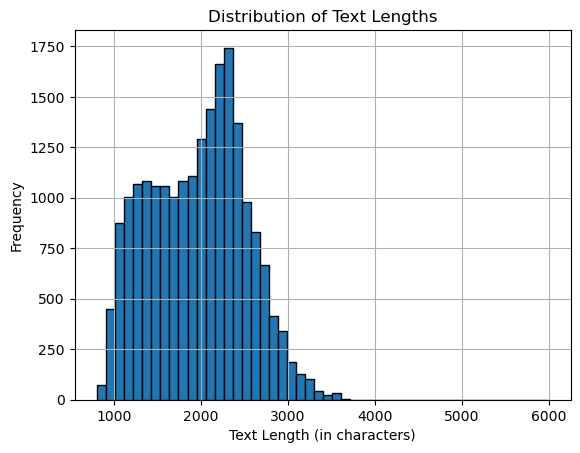

Mean   text length: 1956.1594847996969
Median text length: 2002.0
Max    text length: 5995
Min    text length: 805


In [ ]:
# Distribution of text lengths after filtering by word count

# Calculate the length of each text (in characters)
text_lengths = filtered_by_word_count_df['text'].apply(len)

plt.hist(text_lengths, bins=50, edgecolor='black')
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length (in characters)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# print stats
print("Mean   text length:", np.mean(text_lengths))
print("Median text length:", np.median(text_lengths))
print("Max    text length:", np.max(text_lengths))
print("Min    text length:", np.min(text_lengths))

Number of texts remaining after filtering: 20562


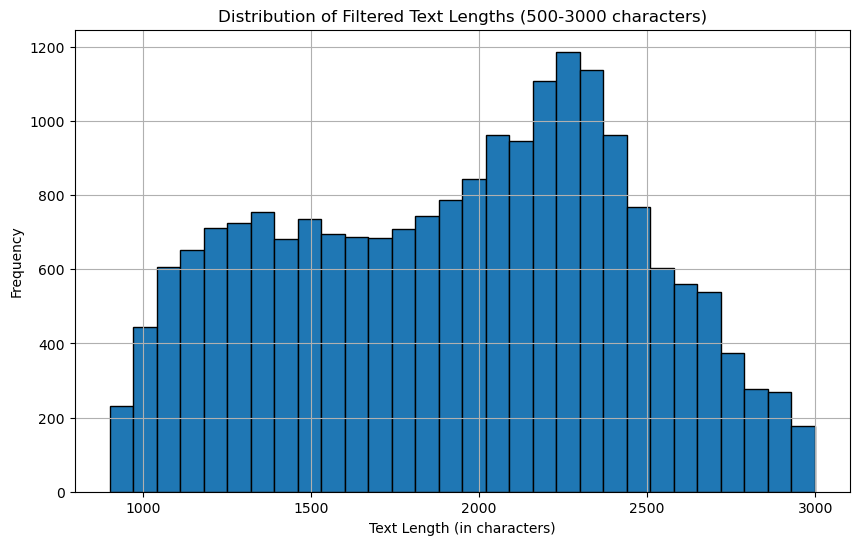

In [ ]:
# Filter the texts based on their length by removing the texts with character lenght below 900 and above 3000 which is good for having an evenly distributed data
filtered_data = filtered_by_word_count_df[(filtered_by_word_count_df['text'].apply(len) >= 900) & (filtered_by_word_count_df['text'].apply(len) <= 3000)]

# number of texts remaining after filtering
print(f"Number of texts remaining after filtering: {len(filtered_data)}")

# Plotting the distribution of filtered text lengths
filtered_text_lengths = filtered_data['text'].apply(len)
plt.figure(figsize=(10, 6))
plt.hist(filtered_text_lengths, bins=30, edgecolor='black')
plt.title('Distribution of Filtered Text Lengths (500-3000 characters)')
plt.xlabel('Text Length (in characters)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

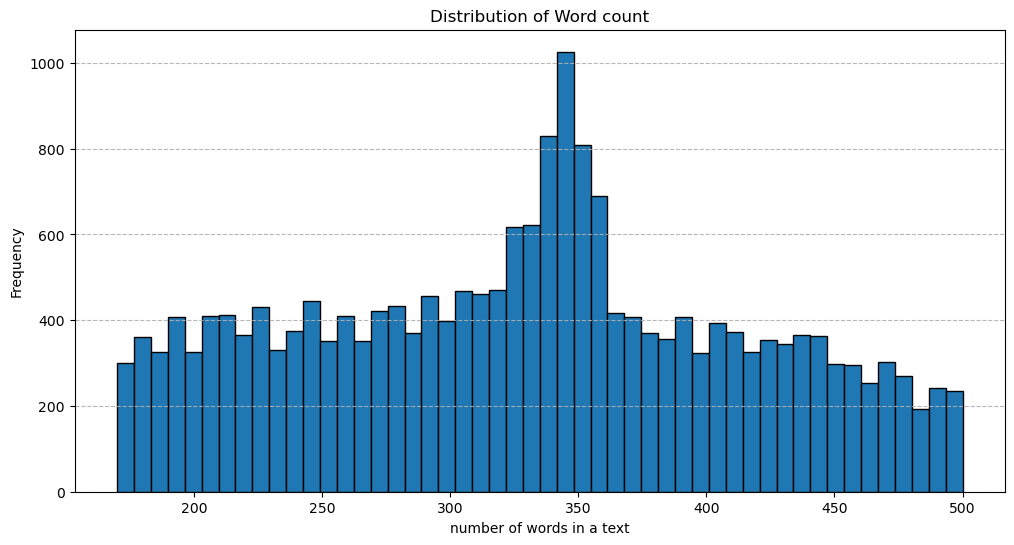

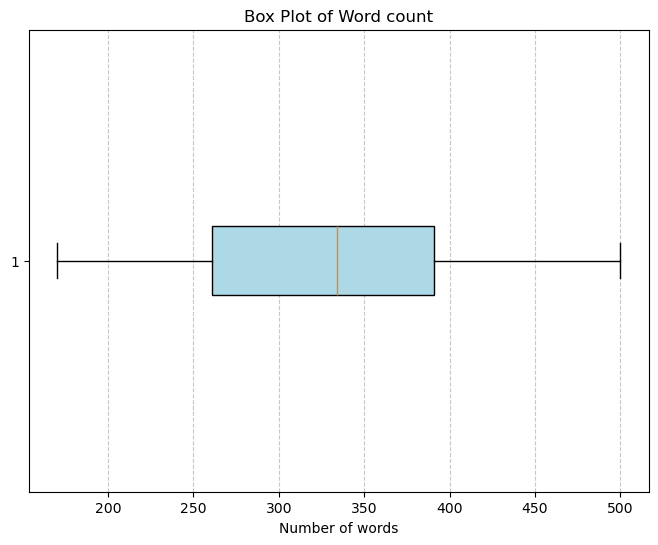

Average word count: 328.73
Median  word count: 334
Minimum word count: 170
Maximum word count: 500


In [ ]:
# Checking the distribution graph again for word count after filtering texts based on the character lenght

# Calculate text lengths
text_lengths = [len(text.split()) for text in filtered_data['text']]

# Plot the histogram
plt.figure(figsize=(12, 6))
plt.hist(text_lengths, bins=50,  edgecolor='black')
plt.title('Distribution of Word count')
plt.xlabel('number of words in a text')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.9)
plt.show()

# Plot the box plot
plt.figure(figsize=(8, 6))
plt.boxplot(text_lengths, vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('Box Plot of Word count')
plt.xlabel('Number of words')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Print stats
print(f"Average word count: {sum(text_lengths) / len(text_lengths):.2f}")
print(f"Median  word count: {sorted(text_lengths)[len(text_lengths) // 2]}")
print(f"Minimum word count: {min(text_lengths)}")
print(f"Maximum word count: {max(text_lengths)}")

In [12]:
filtered_data.shape

(20562, 2)

In [13]:
df = filtered_data

In [ ]:
# Remove the data samples randomly from Human texts to balance the data

generated_count = df['generated'].sum()

human_indices = df[df['generated'] == 0].index
generated_indices = df[df['generated'] == 1].index

# Convert human indices to a pandas Series and sample the same number as generated
human_sampled_indices = pd.Series(human_indices).sample(n=generated_count, random_state=42)

# Create a new balanced dataframe
balanced_df = pd.concat([df.loc[generated_indices], df.loc[human_sampled_indices]])

# Shuffle the dataframe to mix both samples
balanced_df = shuffle(balanced_df, random_state=42)

# print the new distribution
print('Balanced dataset distribution:')
print(balanced_df['generated'].value_counts())

# reset the index
balanced_df = balanced_df.reset_index(drop=True)

Balanced dataset distribution:
generated
0    8774
1    8774
Name: count, dtype: int64


/var/folders/dg/4z_q5hbd4vj4wy03m6qwht3c0000gn/T/ipykernel_79965/2617505794.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=balanced_df['generated'], palette='Set2')


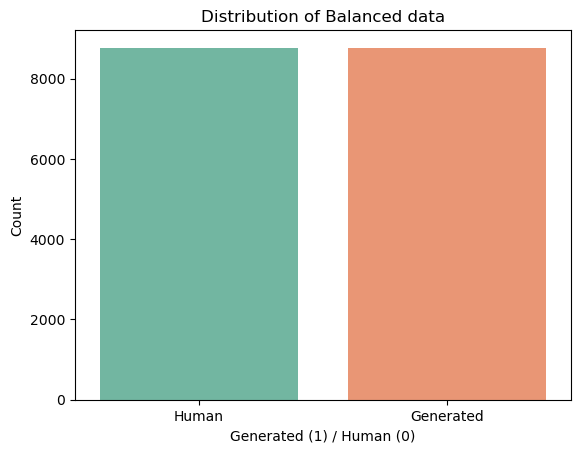

Exact count of labels in 'generated' column:
generated
0    8774
1    8774
Name: count, dtype: int64


In [ ]:
# Plot the distribution of both the labels
ax = sns.countplot(x=balanced_df['generated'], palette='Set2')
plt.title('Distribution of Balanced data')
plt.xlabel('Generated (1) / Human (0)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Human', 'Generated'])
plt.show()

# Print the count
generated_count = balanced_df['generated'].value_counts()
print(f"Exact count of labels in 'generated' column:\n{generated_count}")

In [16]:
# get all words
text = balanced_df.text.values
words = ' '.join(text)
words = words.split() 

# build vocabulary
vocab = sorted(Counter(words), key=Counter(words).get, reverse=True)
ID2W = dict(enumerate(vocab, 1))
ID2W[0] = '<PAD>' # special word for paddding purpose, and the index is 0
vectorizer = {word: ID for ID, word in ID2W.items()}
vectorizer

{'the': 1,
 'to': 2,
 'and': 3,
 'of': 4,
 'a': 5,
 'is': 6,
 'that': 7,
 'in': 8,
 'for': 9,
 'can': 10,
 'it': 11,
 'be': 12,
 'are': 13,
 'you': 14,
 'on': 15,
 'they': 16,
 'have': 17,
 'or': 18,
 'people': 19,
 'not': 20,
 'their': 21,
 'with': 22,
 'more': 23,
 'as': 24,
 'The': 25,
 'this': 26,
 'we': 27,
 'I': 28,
 'by': 29,
 'would': 30,
 'from': 31,
 'because': 32,
 'In': 33,
 'has': 34,
 'will': 35,
 'an': 36,
 'but': 37,
 'also': 38,
 'if': 39,
 'our': 40,
 'your': 41,
 'about': 42,
 'This': 43,
 'should': 44,
 'there': 45,
 'like': 46,
 'help': 47,
 'could': 48,
 'when': 49,
 'one': 50,
 'make': 51,
 'was': 52,
 'how': 53,
 'students': 54,
 'than': 55,
 'what': 56,
 'many': 57,
 'may': 58,
 'who': 59,
 'all': 60,
 'just': 61,
 'do': 62,
 'other': 63,
 'them': 64,
 'at': 65,
 'car': 66,
 'which': 67,
 'get': 68,
 'so': 69,
 'some': 70,
 'use': 71,
 'It': 72,
 'while': 73,
 'time': 74,
 'think': 75,
 'new': 76,
 'such': 77,
 'vote': 78,
 'better': 79,
 'even': 80,
 'only': 8

In [17]:
print('Text sample:', text[0])
num_vec = [vectorizer[w] for w in text[0].split()]
print('Coverted vector:',  len(num_vec), num_vec,)

Text sample: Electoral college has helped in many ways. Many people have suggested keeping the electoral college or changing to election by popular vote for the president of United States. I believe that changing to election by popular vote for the president would be best bescause first the more people who vote its easier to determine who would become president and because it will aviod any problems having to choose for president. Changing the election by popular vote can change things in the united states.

Now a days  alot of things have helped the electoral college but in other cases it has not . Changing to election by popular vote can help by choosing the winner and still having its defenders. Also it may help by when they need to find out the winner they know exactly who it is . They can get their election faster and quicker by changing the election vote to the most popular vote for the united states. People still suggest that keeping the electoral college would be better but chn

In [ ]:
# text vectorization and padding
vecs = [[vectorizer[w] for w in r.split()] for r in tqdm(text)]

# Seq length = 340 which is little more than median and more than average word count
seq_length = 340
    
X = np.full((len(vecs), seq_length), 0, dtype=int)
for i, vec in enumerate(vecs):
    X[i, :len(vec)] = np.array(vec)[:seq_length]

print('Text vectors:', X.shape)
Y = balanced_df.generated.to_numpy()
print('Labels:', Y.shape)

100%|██████████| 17548/17548 [00:00<00:00, 27070.75it/s]


Text vectors: (17548, 340)
Labels: (17548,)


In [19]:
print('Original vector:', vec[0])
print('Results with padding:', X[0])

Original vector: 1512
Results with padding: [   92   128    34  1328     8    57  1055   356    19    17  5546   834
     1   107   128    18   739     2   263    29   121    78     9     1
   194     4   308   971    28   105     7   739     2   263    29   121
    78     9     1   194    30    12   168 30944   215     1    23    19
    59    78    99   396     2  1544    59    30   143   194     3    32
    11    35 13996   113   438   138     2   373     9   442  5062     1
   263    29   121    78    10   199   125     8     1  1752   825  1160
     5   477   930     4   125    17  1328     1   107   128    37     8
    63  2121    11    34    20   129  5062     2   263    29   121    78
    10    47    29   890     1  1204     3   169   138    99 13074   486
    11    58    47    29    49    16   102     2   187    89     1  1204
    16    90  1628    59    11     6   129   117    10    68    21   263
  1285     3  3807    29   739     1   263    78     2     1   104   121
    78 

In [20]:
# Split data into train (70%), validation (15%), and test (15%)
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

print("Train set:", X_train.shape, Y_train.shape)
print("Validation set:", X_val.shape, Y_val.shape)
print("Test set:", X_test.shape, Y_test.shape)

batch_size = 128
train_data = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.long), torch.tensor(Y_train, dtype=torch.float)), batch_size=batch_size, shuffle=True)
val_data = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.long), torch.tensor(Y_val, dtype=torch.float)), batch_size=batch_size)
test_data = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.long), torch.tensor(Y_test, dtype=torch.float)), batch_size=batch_size)

Train set: (12283, 340) (12283,)
Validation set: (2632, 340) (2632,)
Test set: (2633, 340) (2633,)


In [ ]:
vocab_size = len(vectorizer)  # Number of unique words in your vocabulary
embedding_dim = 340
seq_length = 340  # Max sequence length
num_classes = 1

inputs = Input(shape=(seq_length,))
embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=seq_length)(inputs)
cnn = Conv1D(filters=128, kernel_size=5, activation='relu', padding='same')(embedding)
cnn = BatchNormalization()(cnn)
cnn = MaxPooling1D(pool_size=4)(cnn)
cnn = Conv1D(filters=256, kernel_size=3, activation='relu', padding='same')(cnn)
cnn = BatchNormalization()(cnn)
cnn = MaxPooling1D(pool_size=2)(cnn)
lstm = LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)(cnn)
lstm = LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)(lstm)
dense = Dense(256, activation='relu')(lstm)
dense = Dropout(0.5)(dense)
dense = Dense(128, activation='relu')(dense)
dense = Dropout(0.5)(dense)
dense = Dense(64, activation='relu')(dense)
outputs = Dense(num_classes, activation='sigmoid')(dense)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 340)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 340, 340)       │    38,910,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 340, 128)       │       217,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 340, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 85, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 85, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 85, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 42, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 42, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,533,169 (150.81 MB)

 Trainable params: 39,532,401 (150.80 MB)

 Non-trainable params: 768 (3.00 KB)

In [ ]:
# Train the model
history = model.fit(train_data, epochs=10, batch_size=batch_size, validation_data=val_data, verbose=1)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 45s 440ms/step - accuracy: 0.7270 - loss: 0.4558 - val_accuracy: 0.4981 - val_loss: 0.7376
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 424ms/step - accuracy: 0.9908 - loss: 0.0351 - val_accuracy: 0.5011 - val_loss: 0.6906
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 42s 434ms/step - accuracy: 0.9986 - loss: 0.0071 - val_accuracy: 0.6425 - val_loss: 0.6798
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 40s 419ms/step - accuracy: 0.9973 - loss: 0.0082 - val_accuracy: 0.9821 - val_loss: 0.0946
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 40s 417ms/step - accuracy: 0.9987 - loss: 0.0042 - val_accuracy: 0.9890 - val_loss: 0.0403
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 76s 795ms/step - accuracy: 0.9995 - loss: 0.0024 - val_accuracy: 0.9909 - val_loss: 0.0290
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 39s 404ms/step - accuracy: 0.9986 - loss: 0.0065 - val_accuracy: 0.9863 - val_loss: 0.0477
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 39s 402ms/step - accuracy: 0.9985 - loss: 0.0049 - val_accu

In [ ]:
model.save('model.keras')

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.9927 - loss: 0.0141
Test Loss: 0.013440256007015705
Test Accuracy: 0.9935435056686401


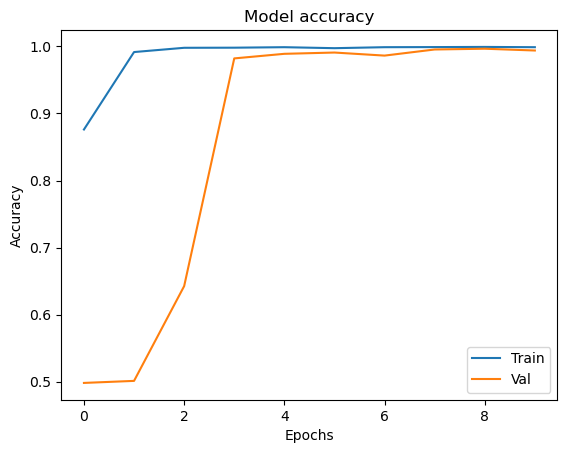

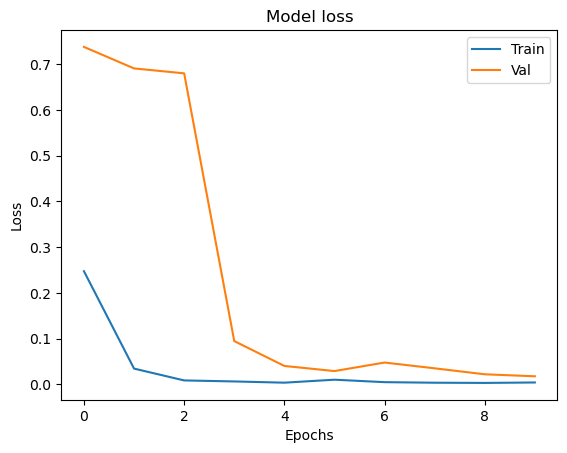

In [47]:
# Plot training & validation accuracy 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'])
plt.show()

# Plot training & validation loss 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'])
plt.show()


In [ ]:
# Predict probabilities
y_pred_prob = model.predict(test_data)
# Convert probabilities to binary (0 or 1)
y_pred = (y_pred_prob > 0.5).astype(int)

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step


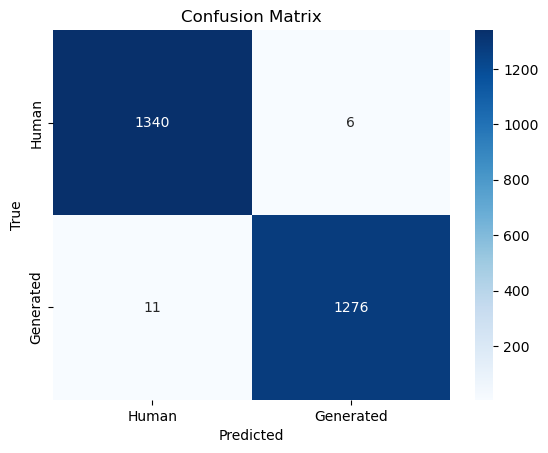

In [ ]:
# Print the confusion matrix
conf_matrix = confusion_matrix(Y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'Generated'], yticklabels=['Human', 'Generated'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
precision = precision_score(Y_test, y_pred)
print("Precision:", precision)

Precision: 0.9953198127925117


In [ ]:
recall = recall_score(Y_test, y_pred)
print("Recall:", recall)

Recall: 0.9914529914529915


In [ ]:
f1 = f1_score(Y_test, y_pred)
print("F1 Score:", f1)

F1 Score: 0.9933826391592059


In [ ]:
print(classification_report(Y_test, y_pred, target_names=['Human', 'Generated']))

              precision    recall  f1-score   support

       Human       0.99      1.00      0.99      1346
   Generated       1.00      0.99      0.99      1287

    accuracy                           0.99      2633
   macro avg       0.99      0.99      0.99      2633
weighted avg       0.99      0.99      0.99      2633

